In [1]:
#First we import the requested modules
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

import json

import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import geopy.distance

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
pio.templates.default = 'plotly_white'
pd.set_option("display.precision", 3)

import pylbm

import datetime
from datetime import timedelta


from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

import time

In [2]:
#Available colors
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]

In [3]:
# DATA
# Madrid Center Coordinates
center_x = -3.703791298326508
center_y = 40.416798812634816

In [4]:
# Distance to Latitude/Longitude Jump
jump_y = 0.1
coords_1 = (center_y, center_x)
coords_2 = (center_y+jump_y, center_x)

dist_y = geopy.distance.distance(coords_1,coords_2).m
lat_dist_ratio = dist_y/jump_y #meters/lat unit

jump_x = 0.1
coords_1 = (center_y, center_x)
coords_2 = (center_y, center_x+jump_x)

dist_x = geopy.distance.distance(coords_1,coords_2).m
lon_dist_ratio = dist_x/jump_x #meters/lon unit

In [5]:
# Meters Jump to Latitude/Longitude Jump
dist_y = 12500
dist_x = 12500
lat_jump = dist_y/lat_dist_ratio
lon_jump = dist_x/lon_dist_ratio

In [6]:
def get_cells(center_x,center_y,lon_jump,lat_jump,d_x,d_y) :
    # Summary of the cells to be constructed
    lower_left_vertex = (center_x-lon_jump,center_y-lat_jump)
    div_size_x = d_x/lon_dist_ratio
    div_size_y = d_y/lat_dist_ratio
    n_divs_x = int(2*lon_jump/div_size_x)
    n_divs_y = int(2*lat_jump/div_size_y)
    n_divs_tot = n_divs_x*n_divs_y
    print('There are {} divs in x axis of size {}º Lon'.format(n_divs_x,div_size_x))
    print('There are {} divs in y axis of size {}º Lat'.format(n_divs_y,div_size_y))
    print('There are {} total divisions'.format(n_divs_tot))

    # Obtain all the centers of the potential cells
    st_lon = lower_left_vertex[0]
    st_lat = lower_left_vertex[1]
    cells = {}
    cells_list = []
    for i_x in range(n_divs_x) :
        cells[i_x] = {}
        for i_y in range(n_divs_y) :
            c_x = st_lon+i_x*div_size_x+div_size_x/2;
            c_y = st_lat+i_y*div_size_y+div_size_y/2;

            cells[i_x][i_y] = {
                'cx' : c_x,
                'cy' : c_y
            }
            
            cells_list.append({
                'ix' : i_x,
                'iy' : i_y,
                'cx' : c_x,
                'cy' : c_y
            })
    
    # Turn dictionary into dataframe to ease the plots
    cells_df = pd.DataFrame(cells_list)

    return cells_df

In [7]:
def identify_buildings(cells_df,buildings_gdf) :
    n_splits =  num_cores*4

    inputs = list(range(n_splits))
    x_splitted = np.array_split(cells_df.cx.tolist(),n_splits)
    y_splitted = np.array_split(cells_df.cy.tolist(),n_splits)
    
    th = 0.001

    # Function to execute in parallel for each split
    def id_buildings(i,x_splitted,y_splitted,th) :
        buildings_i = []
        x_i = x_splitted[i]
        y_i = y_splitted[i]

        for k in range(len(x_i)) :
            buildings_close = buildings_gdf[
                (buildings_gdf.centroid_x < (x_i[k] + th)) & \
                (buildings_gdf.centroid_x > (x_i[k] - th)) & \
                (buildings_gdf.centroid_y < (y_i[k] + th)) & \
                (buildings_gdf.centroid_y > (y_i[k] - th))]
            is_building = buildings_close.contains(Point(x_i[k],y_i[k])).sum() > 0
            buildings_i.append(is_building)
        
        print('Finished processing split {}'.format(i))

        return buildings_i

    # Execute and gather parallel results
    print('PROCESSING {} SPLITS IN PARALLEL'.format(n_splits))
    results = Parallel(n_jobs=num_cores, verbose=10)(delayed(id_buildings)(i,x_splitted,y_splitted,th) for i in inputs)
    
    buildings = sum(results,[])
    
    cells_df['building'] = buildings
    return cells_df

# Madrid Tesellation Data

# SQUARES TESSELLATION

In [8]:
path = 'data/'
tes = pd.read_csv(path+'squares_df_5m_elev_buildings.csv')

In [9]:
tes.sample(10)

,ix,iy,cx,cy,elevation,building
11598706,2319,3706,-3.714,40.471,667.190,False
7597047,1519,2047,-3.762,40.396,660.830,False
3463887,692,3887,-3.810,40.479,668.364,False
22800110,4560,110,-3.582,40.309,539.524,False
11894813,2378,4813,-3.711,40.521,717.485,False
24339197,4867,4197,-3.564,40.493,585.301,False
8540059,1708,59,-3.750,40.307,664.921,False
22118583,4423,3583,-3.590,40.466,648.213,False
12013951,2402,3951,-3.710,40.482,706.326,False
6730643,1346,643,-3.772,40.333,677.169,True


In [10]:
x_size = tes.ix.max()+1
y_size = tes.iy.max()+1
n_cells = tes.shape[0]

In [11]:
grid_x, grid_y = np.mgrid[0:x_size,0:y_size]

In [12]:
X = range(x_size)
Y = range(y_size)

# Plot cells elevation

In [13]:
Z_elev = np.array(tes.elevation.tolist()).reshape(x_size,y_size)
Z_elev = np.transpose(Z_elev)

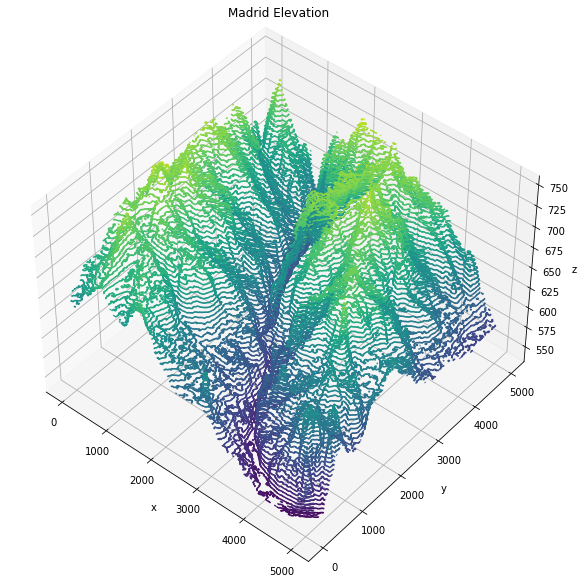

In [14]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z_elev, 50, cmap='viridis')
ax.set_title('Madrid Elevation')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(45, 310)

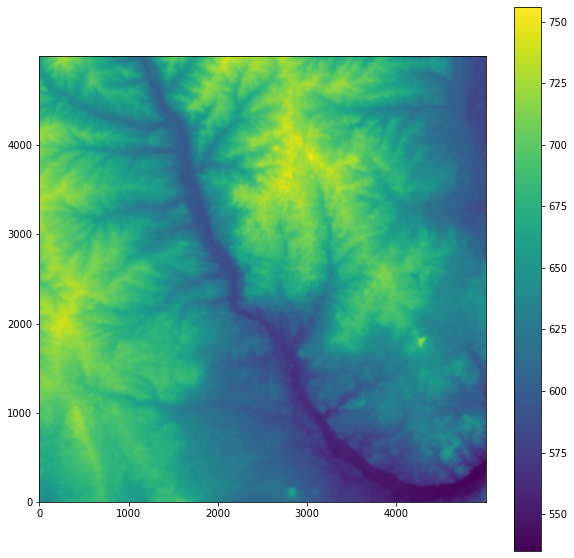

In [15]:
fig = plt.figure(figsize=(10,10))
plt.imshow(Z_elev, cmap=cm.viridis, origin='lower')
plt.colorbar()

# Plot cells building condition

In [16]:
Z_building = np.array(tes.building.tolist()).reshape(x_size,y_size)
Z_building = np.transpose(Z_building)

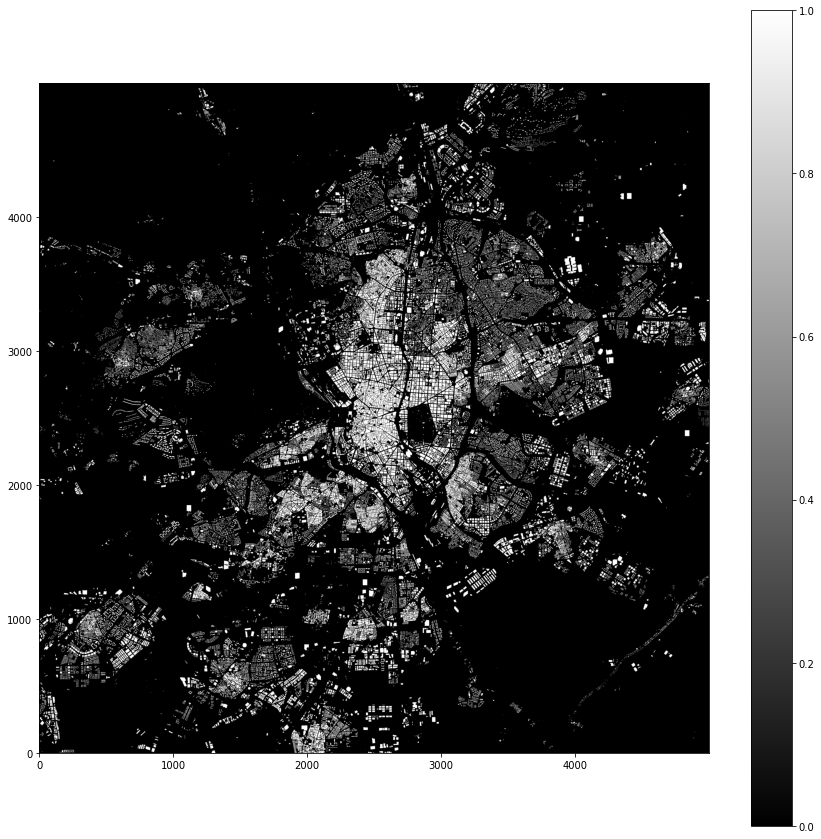

In [17]:
fig = plt.figure(figsize=(15,15))
plt.imshow(Z_building, cmap=cm.gray, origin='lower')
plt.colorbar()

# HEXAGONS TESSELLATION

In [20]:
hex_tes = pd.read_csv(path+'hexagons_df_5m_elev_buildings.csv')

In [22]:
hex_tes.sample(10)

,ix,iy,cx,cy,elevation,building
1326915,229,4898,-3.838,40.495,695.121,False
10015675,1734,5293,-3.749,40.511,690.376,False
18898734,3273,3705,-3.658,40.449,699.103,True
3842641,665,3596,-3.812,40.444,660.469,False
1382236,239,2489,-3.837,40.401,727.499,False
6879104,1191,3461,-3.781,40.439,646.202,False
19693729,3411,2026,-3.650,40.383,663.732,False
22332781,3868,2817,-3.623,40.414,713.312,False
2430810,421,377,-3.826,40.319,681.511,False
9625582,1667,1991,-3.753,40.382,663.043,False


## Plot hexagon lattices

In [23]:
pip install hexalattice

  Using cached hexalattice-1.1.0-py3-none-any.whl
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [24]:
from hexalattice.hexalattice import *

# Squares - Zoom to a small centric area

In [25]:
side_m = 250
d_x = 5

x_size_sm = side_m/lon_dist_ratio
y_size_sm = side_m/lat_dist_ratio
x_st = center_x
y_st = center_y

In [26]:
tes_sm = tes[
    ((tes.cx >= x_st) & (tes.cx < (x_st + x_size_sm))) & \
    ((tes.cy >= y_st) & (tes.cy < (y_st + y_size_sm)))
]

In [27]:
tes_sm.head()

,ix,iy,cx,cy,elevation,building
12502500,2500,2500,-3.704,40.417,662.774,False
12502501,2500,2501,-3.704,40.417,662.774,False
12502502,2500,2502,-3.704,40.417,662.774,False
12502503,2500,2503,-3.704,40.417,662.774,False
12502504,2500,2504,-3.704,40.417,662.774,False


In [28]:
n_x = tes_sm.ix.max()-tes_sm.ix.min()+1
n_y = tes_sm.iy.max()-tes_sm.iy.min()+1
n_x,n_y

(50, 50)

In [29]:
Z_elev = np.array(tes_sm.elevation.tolist()).reshape(n_x,n_y)
Z_elev = np.transpose(Z_elev)

Z_building = np.array(tes_sm.building.tolist()).reshape(n_x,n_y)
Z_building = np.transpose(Z_building)

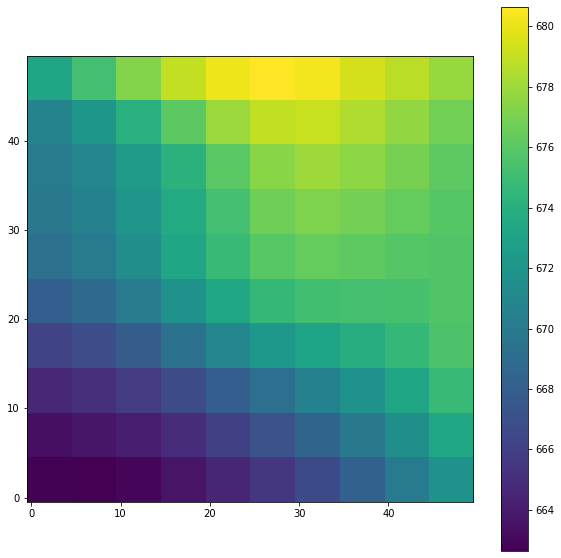

In [30]:
fig = plt.figure(figsize=(10,10))
plt.imshow(Z_elev, cmap=cm.viridis, origin='lower')
plt.colorbar()

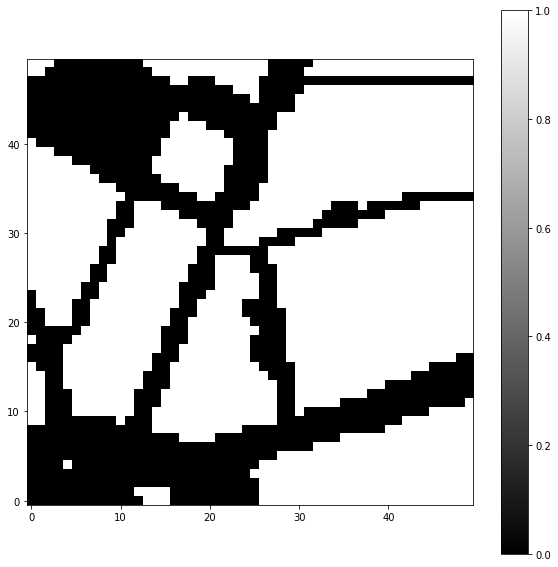

In [31]:
fig = plt.figure(figsize=(10,10))
plt.imshow(Z_building, cmap=cm.gray, origin='lower')
plt.colorbar()

# Hexagons - Zoom to a small centric area

In [32]:
side_m = 250
d_x = 5

x_size_sm = side_m/lon_dist_ratio
y_size_sm = side_m/lat_dist_ratio
x_st = center_x
y_st = center_y

In [33]:
hex_tes_sm = hex_tes[
    ((hex_tes.cx >= x_st) & (hex_tes.cx < (x_st + x_size_sm))) & \
    ((hex_tes.cy >= y_st) & (hex_tes.cy < (y_st + y_size_sm)))
]
hex_tes_sm = hex_tes_sm.sort_values(['iy','ix'],ascending=True)

In [34]:
n_x = hex_tes_sm.ix.max()-hex_tes_sm.ix.min()+1
n_y = hex_tes_sm.iy.max()-hex_tes_sm.iy.min()+1
n_x,n_y

(50, 57)

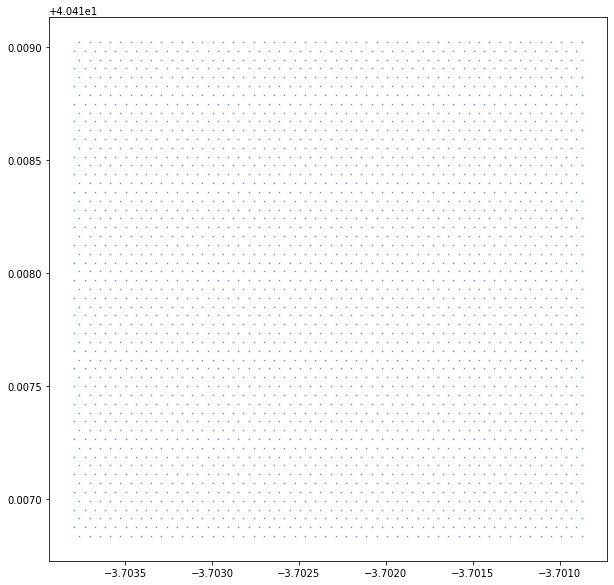

In [35]:
x = hex_tes_sm.cx
y = hex_tes_sm.cy

fig, axs = plt.subplots(ncols=1, figsize=(10, 10))
sc = axs.scatter(x, y, s=0.2)
plt.show()

<AxesSubplot:>

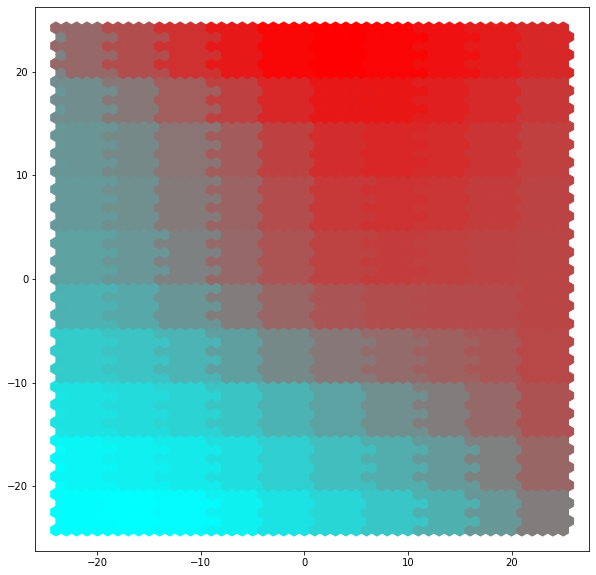

In [36]:
x = hex_tes_sm.ix
y = hex_tes_sm.iy
C = hex_tes_sm.elevation

xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
Cmin = C.min()
Cmax = C.max()

hex_centers, h_ax = create_hex_grid(
    nx=int(xmax-xmin+1), 
    ny=int(ymax-ymin+1), 
    do_plot=False
)

colors = [[(elev-Cmin)/(Cmax-Cmin), 1-(elev-Cmin)/(Cmax-Cmin), 1-(elev-Cmin)/(Cmax-Cmin)] for elev in C]

fig, axs = plt.subplots(ncols=1, figsize=(10, 10))
plot_single_lattice_custom_colors(
    hex_centers[:, 0], hex_centers[:, 1],
    face_color=colors,
    edge_color=colors,
    min_diam=1,
    plotting_gap=0,
    rotate_deg=0,
    h_ax=axs
)

<AxesSubplot:>

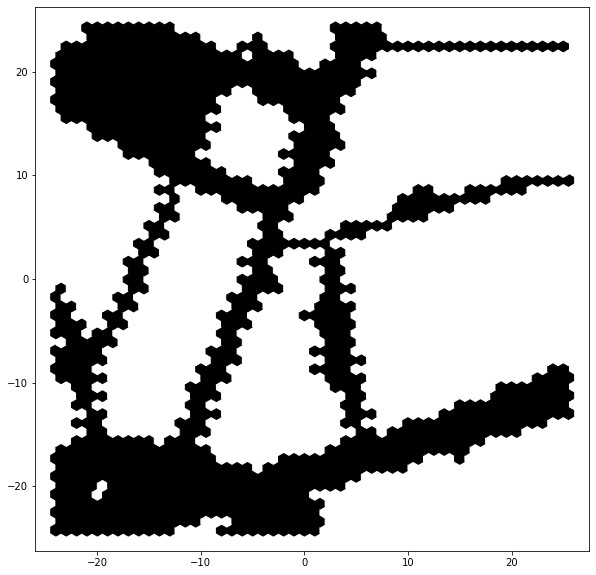

In [37]:
x = hex_tes_sm.ix
y = hex_tes_sm.iy
C = hex_tes_sm.building+0

xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
Cmin = C.min()
Cmax = C.max()

hex_centers, h_ax = create_hex_grid(
    nx=int(xmax-xmin+1), 
    ny=int(ymax-ymin+1), 
    do_plot=False
)

colors = [[b, b, b] for b in C]

fig, axs = plt.subplots(ncols=1, figsize=(10, 10))
plot_single_lattice_custom_colors(
    hex_centers[:, 0], hex_centers[:, 1],
    face_color=colors,
    edge_color=colors,
    min_diam=1,
    plotting_gap=0,
    rotate_deg=0,
    h_ax=axs
)

## Assign precision score to buildings tessellation

In [38]:
#buildings_gdf = gpd.read_file(path+'buildings_madrid.geojson')

In [39]:
# Meters Jump to Latitude/Longitude Jump
dist_y_test = side_m/2
dist_x_test = side_m/2
lat_jump_test = dist_y_test/lat_dist_ratio
lon_jump_test = dist_x_test/lon_dist_ratio

# Side of the rectangles (squares if equal)
d_x_test = 0.25
d_y_test = d_x_test

#Center
center_x_test = center_x + dist_x/lon_dist_ratio
center_y_test = center_y + dist_y/lat_dist_ratio

In [40]:
#Generate test_pts
#test_pts = get_cells(center_x_test,center_y_test,lon_jump_test,lat_jump_test,d_x_test,d_y_test)
#test_pts = identify_buildings(test_pts,buildings_gdf)

#Read from file
test_pts = pd.read_csv(path+'test_pts_25cm_250m.csv')

In [63]:
#fig, axs = plt.subplots(ncols=1, figsize=(10, 10))

x = test_pts.cx
y = test_pts.cy

# sc1 = axs.scatter(x, y, s=0.2)

x = tes_sm.cx
y = tes_sm.cy

# sc2 = axs.scatter(x, y, s=0.2)

x = hex_tes_sm.cx
y = hex_tes_sm.cy

# sc3 = axs.scatter(x, y, s=0.2)

In [64]:
#Save test_pts to file
#test_pts.to_csv(path+'test_pts_25cm_250m.csv', index=False, header=True)

In [127]:
def precision_score (test_pts, tes_pts, tes_shape, d_x) :
    if tes_shape == 'hexagon' :
        r = d_x/np.sqrt(3)
    elif tes_shape == 'square' :
        r = d_x/np.sqrt(2)
    else :
        return 'Error - Shape not recognised, use "hexagon" or "square".'
    
    rlon = (r/lon_dist_ratio)
    rlat = (r/lat_dist_ratio)
    dmax = np.sqrt(rlon**2+rlat**2)
    
    
    txs = test_pts.cx.tolist()
    tys = test_pts.cy.tolist()
    tbuildings = test_pts.building.tolist()
    
    n_splits =  int(num_cores)
    inputs = list(range(n_splits))
    
    txs_splitted = np.array_split(txs,n_splits)
    tys_splitted = np.array_split(tys,n_splits)
    tbuildings_splitted = np.array_split(tbuildings,n_splits)
    
    def is_hit(n,txs_splitted,tys_splitted,tbuildings_splitted) :
        hits_n = []
        txs_n = txs_splitted[n]
        tys_n = tys_splitted[n]
        tbuildings_n = tbuildings_splitted[n]
        
        for i in range(len(txs_n)) :
            
            c_in_r_square = tes_pts[
                ((tes_pts.cx > txs_n[i] - 1.2*rlon) & (tes_pts.cx < (txs_n[i] + 1.2*rlon))) & \
                ((tes_pts.cy > tys_n[i] - 1.2*rlat) & (tes_pts.cy < (tys_n[i] + 1.2*rlat)))
            ]
            
            print(c_in_r_square)
            
            if c_in_r_square.shape[0] > 0 :
                cxs_close = c_in_r_square.cx.tolist()
                cys_close = c_in_r_square.cy.tolist()
                cbuildings_close = c_in_r_square.building.tolist()
                
                kcloser = -1
                d_th = dmax
                for k in range(len(cxs_close)) :
                    dist = np.sqrt((cxs_close[k]-txs[i])**2+(cys_close[k]-tys[i])**2)
                    
                    if dist <= d_th :
                        d_th = dist
                        kcloser = k
                        
                if kcloser == -1 :
                    hits_n.append(-1)
                else :
                    hits_n.append(int(cbuildings_close[k] == tbuildings_n[i]))
            else :
                print('Empty')
                hits_n.append(-1)
                
        return hits_n
    
    # Execute and gather parallel results
    #print('PROCESSING {} SPLITS IN PARALLEL'.format(n_splits))
    #results = Parallel(n_jobs=num_cores, verbose=10)(delayed(is_hit)(n,txs_splitted,tys_splitted,tbuildings_splitted) for n in inputs)
    
    #hits = sum(results,[])
    
    hits = is_hit(1,txs_splitted,tys_splitted,tbuildings_splitted)
    return hits

In [120]:
sq_hits = precision_score(
    test_pts = test_pts, 
    tes_pts = tes_sm, 
    tes_shape = 'square', 
    d_x = 5
)

In [121]:
sq_precision = round(sum(sq_hits)/len(sq_hits)*100,3)
print('Square tessellation precision = {}%'.format(sq_precision))

Square tessellation precision = -100.0%


ValueError: 'c' argument has 62375 elements, which is inconsistent with 'x' and 'y' with size 998001.

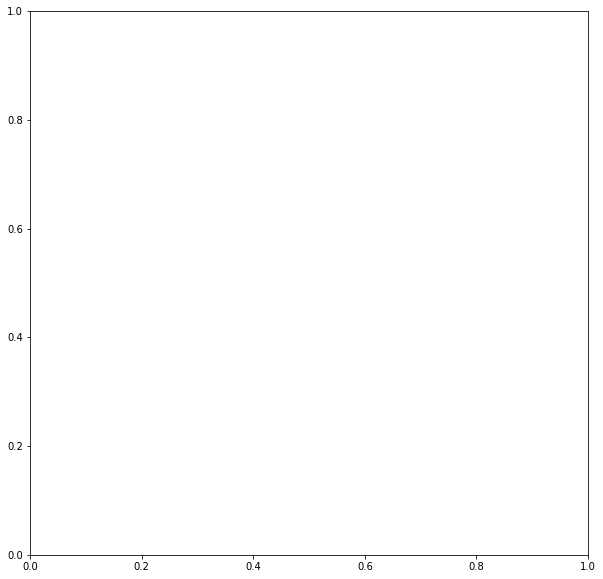

In [125]:
fig, axs = plt.subplots(ncols=1, figsize=(10, 10))

x = test_pts.ix
y = test_pts.iy

sc_sq = axs.scatter(x, y, s=0.2, c=sq_hits)

In [128]:
hex_hits = precision_score(
    test_pts = test_pts, 
    tes_pts = hex_tes_sm, 
    tes_shape = 'hexagon', 
    d_x = 5
)

            ix    iy     cx      cy  elevation  building
14446957  2502  2911 -3.704  40.418    668.049      True
14452730  2503  2911 -3.704  40.418    668.049      True
14452731  2503  2912 -3.704  40.418    668.049      True
            ix    iy     cx      cy  elevation  building
14446957  2502  2911 -3.704  40.418    668.049      True
14452730  2503  2911 -3.704  40.418    668.049      True
14452731  2503  2912 -3.704  40.418    668.049      True
            ix    iy     cx      cy  elevation  building
14446957  2502  2911 -3.704  40.418    668.049      True
14452730  2503  2911 -3.704  40.418    668.049      True
14452731  2503  2912 -3.704  40.418    668.049      True
            ix    iy     cx      cy  elevation  building
14446957  2502  2911 -3.704  40.418    668.049      True
14452730  2503  2911 -3.704  40.418    668.049      True
14452731  2503  2912 -3.704  40.418    668.049      True
            ix    iy     cx      cy  elevation  building
14446957  2502  2911 -3.704  40

14452733  2503  2914 -3.704  40.418    668.049      True
            ix    iy     cx      cy  elevation  building
14446959  2502  2913 -3.704  40.418    668.049      True
14452732  2503  2913 -3.704  40.418    668.049      True
14452733  2503  2914 -3.704  40.418    668.049      True
            ix    iy     cx      cy  elevation  building
14446959  2502  2913 -3.704  40.418    668.049      True
14452732  2503  2913 -3.704  40.418    668.049      True
14452733  2503  2914 -3.704  40.418    668.049      True
            ix    iy     cx      cy  elevation  building
14452733  2503  2914 -3.704  40.418    668.049      True
            ix    iy     cx      cy  elevation  building
14452733  2503  2914 -3.704  40.418    668.049      True
            ix    iy     cx      cy  elevation  building
14452733  2503  2914 -3.704  40.418    668.049      True
            ix    iy     cx      cy  elevation  building
14452733  2503  2914 -3.704  40.418    668.049      True
            ix    iy     cx    

14452736  2503  2917 -3.704  40.418     669.28      True
            ix    iy     cx      cy  elevation  building
14452735  2503  2916 -3.704  40.418     669.28      True
14446963  2502  2917 -3.704  40.418     669.28      True
14452736  2503  2917 -3.704  40.418     669.28      True
            ix    iy     cx      cy  elevation  building
14452735  2503  2916 -3.704  40.418     669.28      True
14446963  2502  2917 -3.704  40.418     669.28      True
14452736  2503  2917 -3.704  40.418     669.28      True
            ix    iy     cx      cy  elevation  building
14452735  2503  2916 -3.704  40.418     669.28      True
14446963  2502  2917 -3.704  40.418     669.28      True
14452736  2503  2917 -3.704  40.418     669.28      True
            ix    iy     cx      cy  elevation  building
14452735  2503  2916 -3.704  40.418     669.28      True
14446963  2502  2917 -3.704  40.418     669.28      True
14452736  2503  2917 -3.704  40.418     669.28      True
            ix    iy     cx    

14452738  2503  2919 -3.704  40.418     669.28      True
            ix    iy     cx      cy  elevation  building
14452737  2503  2918 -3.704  40.418     669.28      True
14446965  2502  2919 -3.704  40.418     669.28      True
14452738  2503  2919 -3.704  40.418     669.28      True
            ix    iy     cx      cy  elevation  building
14452737  2503  2918 -3.704  40.418     669.28      True
14446965  2502  2919 -3.704  40.418     669.28      True
14452738  2503  2919 -3.704  40.418     669.28      True
            ix    iy     cx      cy  elevation  building
14452737  2503  2918 -3.704  40.418     669.28      True
14446965  2502  2919 -3.704  40.418     669.28      True
14452738  2503  2919 -3.704  40.418     669.28      True
            ix    iy     cx      cy  elevation  building
14446965  2502  2919 -3.704  40.418     669.28      True
14452738  2503  2919 -3.704  40.418     669.28      True
            ix    iy     cx      cy  elevation  building
14446965  2502  2919 -3.704  40

14452740  2503  2921 -3.704  40.418    669.869      True
            ix    iy     cx      cy  elevation  building
14446967  2502  2921 -3.704  40.418    669.869      True
14452740  2503  2921 -3.704  40.418    669.869      True
            ix    iy     cx      cy  elevation  building
14446967  2502  2921 -3.704  40.418    669.869      True
14452740  2503  2921 -3.704  40.418    669.869      True
            ix    iy     cx      cy  elevation  building
14446967  2502  2921 -3.704  40.418    669.869      True
14452740  2503  2921 -3.704  40.418    669.869      True
            ix    iy     cx      cy  elevation  building
14446967  2502  2921 -3.704  40.418    669.869      True
14452740  2503  2921 -3.704  40.418    669.869      True
14452741  2503  2922 -3.704  40.418    669.869      True
            ix    iy     cx      cy  elevation  building
14446967  2502  2921 -3.704  40.418    669.869      True
14452740  2503  2921 -3.704  40.418    669.869      True
14452741  2503  2922 -3.704  40

14452743  2503  2924 -3.704  40.418    669.869      True
            ix    iy     cx      cy  elevation  building
14446969  2502  2923 -3.704  40.418    669.869      True
14452742  2503  2923 -3.704  40.418    669.869      True
14452743  2503  2924 -3.704  40.418    669.869      True
            ix    iy     cx      cy  elevation  building
14446969  2502  2923 -3.704  40.418    669.869      True
14452742  2503  2923 -3.704  40.418    669.869      True
14452743  2503  2924 -3.704  40.418    669.869      True
            ix    iy     cx      cy  elevation  building
14446969  2502  2923 -3.704  40.418    669.869      True
14452742  2503  2923 -3.704  40.418    669.869      True
14452743  2503  2924 -3.704  40.418    669.869      True
            ix    iy     cx      cy  elevation  building
14446969  2502  2923 -3.704  40.418    669.869      True
14452742  2503  2923 -3.704  40.418    669.869      True
14452743  2503  2924 -3.704  40.418    669.869      True
            ix    iy     cx    

14452745  2503  2926 -3.704  40.418    669.869      True
            ix    iy     cx      cy  elevation  building
14452745  2503  2926 -3.704  40.418    669.869      True
            ix    iy     cx      cy  elevation  building
14452745  2503  2926 -3.704  40.418    669.869      True
            ix    iy     cx      cy  elevation  building
14452745  2503  2926 -3.704  40.418    669.869      True
            ix    iy     cx      cy  elevation  building
14452745  2503  2926 -3.704  40.418    669.869      True
            ix    iy     cx      cy  elevation  building
14452745  2503  2926 -3.704  40.418    669.869      True
            ix    iy     cx      cy  elevation  building
14452745  2503  2926 -3.704  40.418    669.869      True
14446973  2502  2927 -3.704  40.418    670.126      True
14452746  2503  2927 -3.704  40.418    670.126      True
            ix    iy     cx      cy  elevation  building
14452745  2503  2926 -3.704  40.418    669.869      True
14446973  2502  2927 -3.704  40

14452748  2503  2929 -3.704  40.418    670.126      True
            ix    iy     cx      cy  elevation  building
14452747  2503  2928 -3.704  40.418    670.126      True
14446975  2502  2929 -3.704  40.418    670.126      True
14452748  2503  2929 -3.704  40.418    670.126      True
            ix    iy     cx      cy  elevation  building
14452747  2503  2928 -3.704  40.418    670.126      True
14446975  2502  2929 -3.704  40.418    670.126      True
14452748  2503  2929 -3.704  40.418    670.126      True
            ix    iy     cx      cy  elevation  building
14452747  2503  2928 -3.704  40.418    670.126      True
14446975  2502  2929 -3.704  40.418    670.126      True
14452748  2503  2929 -3.704  40.418    670.126      True
            ix    iy     cx      cy  elevation  building
14452747  2503  2928 -3.704  40.418    670.126      True
14446975  2502  2929 -3.704  40.418    670.126      True
14452748  2503  2929 -3.704  40.418    670.126      True
            ix    iy     cx    

14452750  2503  2931 -3.704  40.419    670.126      True
            ix    iy     cx      cy  elevation  building
14446977  2502  2931 -3.704  40.419    670.126      True
14452750  2503  2931 -3.704  40.419    670.126      True
            ix    iy     cx      cy  elevation  building
14446977  2502  2931 -3.704  40.419    670.126      True
14452750  2503  2931 -3.704  40.419    670.126      True
            ix    iy     cx      cy  elevation  building
14446977  2502  2931 -3.704  40.419    670.126      True
14452750  2503  2931 -3.704  40.419    670.126      True
            ix    iy     cx      cy  elevation  building
14446977  2502  2931 -3.704  40.419    670.126      True
14452750  2503  2931 -3.704  40.419    670.126      True
            ix    iy     cx      cy  elevation  building
14446977  2502  2931 -3.704  40.419    670.126      True
14452750  2503  2931 -3.704  40.419    670.126      True
            ix    iy     cx      cy  elevation  building
14446977  2502  2931 -3.704  40

14452753  2503  2934 -3.704  40.419    670.662     False
            ix    iy     cx      cy  elevation  building
14446979  2502  2933 -3.704  40.419    670.662     False
14452752  2503  2933 -3.704  40.419    670.662     False
14452753  2503  2934 -3.704  40.419    670.662     False
            ix    iy     cx      cy  elevation  building
14446979  2502  2933 -3.704  40.419    670.662     False
14452752  2503  2933 -3.704  40.419    670.662     False
14452753  2503  2934 -3.704  40.419    670.662     False
            ix    iy     cx      cy  elevation  building
14446979  2502  2933 -3.704  40.419    670.662     False
14452752  2503  2933 -3.704  40.419    670.662     False
14452753  2503  2934 -3.704  40.419    670.662     False
            ix    iy     cx      cy  elevation  building
14446979  2502  2933 -3.704  40.419    670.662     False
14452752  2503  2933 -3.704  40.419    670.662     False
14452753  2503  2934 -3.704  40.419    670.662     False
            ix    iy     cx    

14452755  2503  2936 -3.704  40.419    670.662     False
            ix    iy     cx      cy  elevation  building
14446981  2502  2935 -3.704  40.419    670.662     False
14452754  2503  2935 -3.704  40.419    670.662     False
14452755  2503  2936 -3.704  40.419    670.662     False
            ix    iy     cx      cy  elevation  building
14446981  2502  2935 -3.704  40.419    670.662     False
14452754  2503  2935 -3.704  40.419    670.662     False
14452755  2503  2936 -3.704  40.419    670.662     False
            ix    iy     cx      cy  elevation  building
14446981  2502  2935 -3.704  40.419    670.662     False
14452754  2503  2935 -3.704  40.419    670.662     False
14452755  2503  2936 -3.704  40.419    670.662     False
            ix    iy     cx      cy  elevation  building
14452755  2503  2936 -3.704  40.419    670.662     False
            ix    iy     cx      cy  elevation  building
14452755  2503  2936 -3.704  40.419    670.662     False
            ix    iy     cx    

14452757  2503  2938 -3.704  40.419    673.268     False
            ix    iy     cx      cy  elevation  building
14452757  2503  2938 -3.704  40.419    673.268     False
14446985  2502  2939 -3.704  40.419    673.268     False
14452758  2503  2939 -3.704  40.419    673.268     False
            ix    iy     cx      cy  elevation  building
14452757  2503  2938 -3.704  40.419    673.268     False
14446985  2502  2939 -3.704  40.419    673.268     False
14452758  2503  2939 -3.704  40.419    673.268     False
            ix    iy     cx      cy  elevation  building
14452757  2503  2938 -3.704  40.419    673.268     False
14446985  2502  2939 -3.704  40.419    673.268     False
14452758  2503  2939 -3.704  40.419    673.268     False
            ix    iy     cx      cy  elevation  building
14452757  2503  2938 -3.704  40.419    673.268     False
14446985  2502  2939 -3.704  40.419    673.268     False
14452758  2503  2939 -3.704  40.419    673.268     False
            ix    iy     cx    

14452760  2503  2941 -3.704  40.419    673.268     False
            ix    iy     cx      cy  elevation  building
14452759  2503  2940 -3.704  40.419    673.268     False
14446987  2502  2941 -3.704  40.419    673.268     False
14452760  2503  2941 -3.704  40.419    673.268     False
            ix    iy     cx      cy  elevation  building
14452759  2503  2940 -3.704  40.419    673.268     False
14446987  2502  2941 -3.704  40.419    673.268     False
14452760  2503  2941 -3.704  40.419    673.268     False
            ix    iy     cx      cy  elevation  building
14452759  2503  2940 -3.704  40.419    673.268     False
14446987  2502  2941 -3.704  40.419    673.268     False
14452760  2503  2941 -3.704  40.419    673.268     False
            ix    iy     cx      cy  elevation  building
14452759  2503  2940 -3.704  40.419    673.268     False
14446987  2502  2941 -3.704  40.419    673.268     False
14452760  2503  2941 -3.704  40.419    673.268     False
            ix    iy     cx    

14452762  2503  2943 -3.704  40.419    673.268     False
            ix    iy     cx      cy  elevation  building
14446989  2502  2943 -3.704  40.419    673.268      True
14452762  2503  2943 -3.704  40.419    673.268     False
            ix    iy     cx      cy  elevation  building
14446989  2502  2943 -3.704  40.419    673.268      True
14452762  2503  2943 -3.704  40.419    673.268     False
            ix    iy     cx      cy  elevation  building
14446989  2502  2943 -3.704  40.419    673.268      True
14452762  2503  2943 -3.704  40.419    673.268     False
            ix    iy     cx      cy  elevation  building
14446989  2502  2943 -3.704  40.419    673.268      True
14452762  2503  2943 -3.704  40.419    673.268     False
            ix    iy     cx      cy  elevation  building
14446989  2502  2943 -3.704  40.419    673.268      True
14452762  2503  2943 -3.704  40.419    673.268     False
            ix    iy     cx      cy  elevation  building
14446989  2502  2943 -3.704  40

14452707  2503  2888 -3.704  40.417    662.774     False
            ix    iy     cx      cy  elevation  building
14452707  2503  2888 -3.704  40.417    662.774     False
            ix    iy     cx      cy  elevation  building
14452707  2503  2888 -3.704  40.417    662.774     False
            ix    iy     cx      cy  elevation  building
14452707  2503  2888 -3.704  40.417    662.774     False
14446935  2502  2889 -3.704  40.417    662.774     False
14452708  2503  2889 -3.704  40.417    662.774     False
            ix    iy     cx      cy  elevation  building
14452707  2503  2888 -3.704  40.417    662.774     False
14446935  2502  2889 -3.704  40.417    662.774     False
14452708  2503  2889 -3.704  40.417    662.774     False
            ix    iy     cx      cy  elevation  building
14452707  2503  2888 -3.704  40.417    662.774     False
14446935  2502  2889 -3.704  40.417    662.774     False
14452708  2503  2889 -3.704  40.417    662.774     False
            ix    iy     cx    

14452710  2503  2891 -3.704  40.417    662.774     False
            ix    iy     cx      cy  elevation  building
14452709  2503  2890 -3.704  40.417    662.774     False
14446937  2502  2891 -3.704  40.417    662.774     False
14452710  2503  2891 -3.704  40.417    662.774     False
            ix    iy     cx      cy  elevation  building
14452709  2503  2890 -3.704  40.417    662.774     False
14446937  2502  2891 -3.704  40.417    662.774     False
14452710  2503  2891 -3.704  40.417    662.774     False
            ix    iy     cx      cy  elevation  building
14452709  2503  2890 -3.704  40.417    662.774     False
14446937  2502  2891 -3.704  40.417    662.774     False
14452710  2503  2891 -3.704  40.417    662.774     False
            ix    iy     cx      cy  elevation  building
14452709  2503  2890 -3.704  40.417    662.774     False
14446937  2502  2891 -3.704  40.417    662.774     False
14452710  2503  2891 -3.704  40.417    662.774     False
            ix    iy     cx    

14452712  2503  2893 -3.704  40.417    663.362     False
            ix    iy     cx      cy  elevation  building
14446939  2502  2893 -3.704  40.417    663.362     False
14452712  2503  2893 -3.704  40.417    663.362     False
            ix    iy     cx      cy  elevation  building
14446939  2502  2893 -3.704  40.417    663.362     False
14452712  2503  2893 -3.704  40.417    663.362     False
            ix    iy     cx      cy  elevation  building
14446939  2502  2893 -3.704  40.417    663.362     False
14452712  2503  2893 -3.704  40.417    663.362     False
            ix    iy     cx      cy  elevation  building
14446939  2502  2893 -3.704  40.417    663.362     False
14452712  2503  2893 -3.704  40.417    663.362     False
            ix    iy     cx      cy  elevation  building
14446939  2502  2893 -3.704  40.417    663.362     False
14452712  2503  2893 -3.704  40.417    663.362     False
            ix    iy     cx      cy  elevation  building
14446939  2502  2893 -3.704  40

14452715  2503  2896 -3.704  40.417    663.362     False
            ix    iy     cx      cy  elevation  building
14446941  2502  2895 -3.704  40.417    663.362     False
14452714  2503  2895 -3.704  40.417    663.362     False
14452715  2503  2896 -3.704  40.417    663.362     False
            ix    iy     cx      cy  elevation  building
14446941  2502  2895 -3.704  40.417    663.362     False
14452714  2503  2895 -3.704  40.417    663.362     False
14452715  2503  2896 -3.704  40.417    663.362     False
            ix    iy     cx      cy  elevation  building
14446941  2502  2895 -3.704  40.417    663.362     False
14452714  2503  2895 -3.704  40.417    663.362     False
14452715  2503  2896 -3.704  40.417    663.362     False
            ix    iy     cx      cy  elevation  building
14446941  2502  2895 -3.704  40.417    663.362     False
14452714  2503  2895 -3.704  40.417    663.362     False
14452715  2503  2896 -3.704  40.417    663.362     False
            ix    iy     cx    

14452717  2503  2898 -3.704  40.417    664.725     False
            ix    iy     cx      cy  elevation  building
14452717  2503  2898 -3.704  40.417    664.725     False
            ix    iy     cx      cy  elevation  building
14452717  2503  2898 -3.704  40.417    664.725     False
            ix    iy     cx      cy  elevation  building
14452717  2503  2898 -3.704  40.417    664.725     False
            ix    iy     cx      cy  elevation  building
14452717  2503  2898 -3.704  40.417    664.725     False
            ix    iy     cx      cy  elevation  building
14452717  2503  2898 -3.704  40.417    664.725     False
            ix    iy     cx      cy  elevation  building
14452717  2503  2898 -3.704  40.417    664.725     False
            ix    iy     cx      cy  elevation  building
14452717  2503  2898 -3.704  40.417    664.725     False
            ix    iy     cx      cy  elevation  building
14452717  2503  2898 -3.704  40.417    664.725     False
14446945  2502  2899 -3.704  40

14452720  2503  2901 -3.704  40.417    664.725     False
            ix    iy     cx      cy  elevation  building
14452719  2503  2900 -3.704  40.417    664.725     False
14446947  2502  2901 -3.704  40.417    664.725     False
14452720  2503  2901 -3.704  40.417    664.725     False
            ix    iy     cx      cy  elevation  building
14452719  2503  2900 -3.704  40.417    664.725     False
14446947  2502  2901 -3.704  40.417    664.725     False
14452720  2503  2901 -3.704  40.417    664.725     False
            ix    iy     cx      cy  elevation  building
14452719  2503  2900 -3.704  40.417    664.725     False
14446947  2502  2901 -3.704  40.417    664.725     False
14452720  2503  2901 -3.704  40.417    664.725     False
            ix    iy     cx      cy  elevation  building
14452719  2503  2900 -3.704  40.417    664.725     False
14446947  2502  2901 -3.704  40.417    664.725     False
14452720  2503  2901 -3.704  40.417    664.725     False
            ix    iy     cx    

14452722  2503  2903 -3.704  40.417    664.725     False
            ix    iy     cx      cy  elevation  building
14452721  2503  2902 -3.704  40.417    664.725     False
14446949  2502  2903 -3.704  40.417    664.725     False
14452722  2503  2903 -3.704  40.417    664.725     False
            ix    iy     cx      cy  elevation  building
14446949  2502  2903 -3.704  40.417    664.725     False
14452722  2503  2903 -3.704  40.417    664.725     False
            ix    iy     cx      cy  elevation  building
14446949  2502  2903 -3.704  40.417    664.725     False
14452722  2503  2903 -3.704  40.417    664.725     False
            ix    iy     cx      cy  elevation  building
14446949  2502  2903 -3.704  40.417    664.725     False
14452722  2503  2903 -3.704  40.417    664.725     False
            ix    iy     cx      cy  elevation  building
14446949  2502  2903 -3.704  40.417    664.725     False
14452722  2503  2903 -3.704  40.417    664.725     False
            ix    iy     cx    

14452724  2503  2905 -3.704  40.418    666.338     False
            ix    iy     cx      cy  elevation  building
14446951  2502  2905 -3.704  40.418    666.338     False
14452724  2503  2905 -3.704  40.418    666.338     False
14452725  2503  2906 -3.704  40.418    666.338     False
            ix    iy     cx      cy  elevation  building
14446951  2502  2905 -3.704  40.418    666.338     False
14452724  2503  2905 -3.704  40.418    666.338     False
14452725  2503  2906 -3.704  40.418    666.338     False
            ix    iy     cx      cy  elevation  building
14446951  2502  2905 -3.704  40.418    666.338     False
14452724  2503  2905 -3.704  40.418    666.338     False
14452725  2503  2906 -3.704  40.418    666.338     False
            ix    iy     cx      cy  elevation  building
14446951  2502  2905 -3.704  40.418    666.338     False
14452724  2503  2905 -3.704  40.418    666.338     False
14452725  2503  2906 -3.704  40.418    666.338     False
            ix    iy     cx    

14452727  2503  2908 -3.704  40.418    666.338     False
            ix    iy     cx      cy  elevation  building
14446953  2502  2907 -3.704  40.418    666.338     False
14452726  2503  2907 -3.704  40.418    666.338     False
14452727  2503  2908 -3.704  40.418    666.338     False
            ix    iy     cx      cy  elevation  building
14446953  2502  2907 -3.704  40.418    666.338     False
14452726  2503  2907 -3.704  40.418    666.338     False
14452727  2503  2908 -3.704  40.418    666.338     False
            ix    iy     cx      cy  elevation  building
14446953  2502  2907 -3.704  40.418    666.338     False
14452726  2503  2907 -3.704  40.418    666.338     False
14452727  2503  2908 -3.704  40.418    666.338     False
            ix    iy     cx      cy  elevation  building
14446953  2502  2907 -3.704  40.418    666.338     False
14452726  2503  2907 -3.704  40.418    666.338     False
14452727  2503  2908 -3.704  40.418    666.338     False
            ix    iy     cx    

KeyboardInterrupt: 

In [111]:
hex_precision = round(sum(hex_hits)/len(hex_hits)*100,3)
print('Hexagon tessellation precision = {}%'.format(hex_precision))

Hexagon tessellation precision = -2.561%


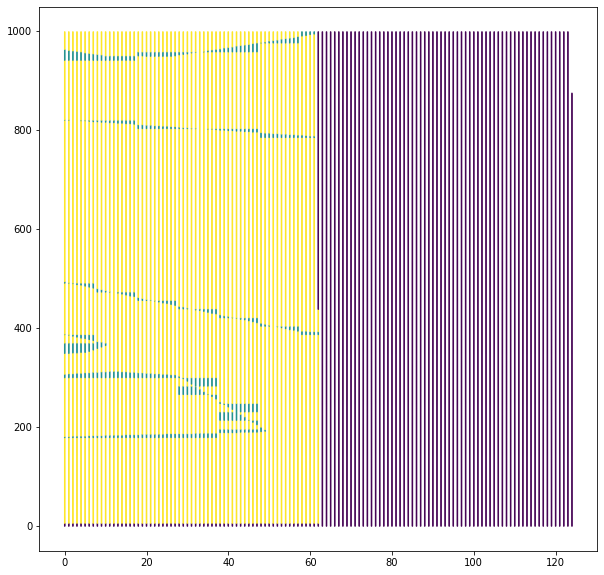

In [113]:
fig, axs = plt.subplots(ncols=1, figsize=(10, 10))

x = test_pts.ix[0:62376]
y = test_pts.iy[0:62376]

sc_hex = axs.scatter(x, y, s=0.2, c=hex_hits)

# Assign height to buildings

In [193]:
mean_height_center = 30 #m
min_elev_2km = np.min(Z_elev)

In [194]:
Z_tot = Z_building*mean_height_center #+ Z_elev

# Plot 3D Model - Elevation & Buildings

In [195]:
def barchart3d(z_data, title, z_title,
               n_row=0, width=900, height=900, thikness=1, colorscale='Viridis',
               **kwargs):
    """
    Draws a 3D barchart
    :param z_data: Array_like of bar heights (data coords)
    :param title: Chart title
    :param z_title: Z-axis title
    :param n_row: Number of x-rows
    :param width: Chart width (px)
    :param height: Chart height (px)
    :param thikness: Bar thikness (0; 1)
    :param colorscale: Barchart colorscale
    :param **kwargs: Passed to Mesh3d()
    :return: 3D barchart figure
    """

    if n_row < 1:
        n_row = math.ceil(math.sqrt(len(z_data)))
    thikness *= 0.5
    ann = []
    
    fig = go.Figure()

    for iz, z_max in enumerate(z_data):
        x_cnt, y_cnt = iz % n_row, iz // n_row
        x_min, y_min = x_cnt - thikness, y_cnt - thikness
        x_max, y_max = x_cnt + thikness, y_cnt + thikness

        fig.add_trace(go.Mesh3d(
            x=[x_min, x_min, x_max, x_max, x_min, x_min, x_max, x_max],
            y=[y_min, y_max, y_max, y_min, y_min, y_max, y_max, y_min],
            z=[0, 0, 0, 0, z_max, z_max, z_max, z_max],
            alphahull=0,
            intensity=[0, 0, 0, 0, z_max, z_max, z_max, z_max],
            coloraxis='coloraxis',
            hoverinfo='skip',
            **kwargs))

    fig.update_layout(
        width=width, height=height,
        title=title, title_x=0.5,
        scene=dict(
            xaxis=dict(showticklabels=False, title=''),
            yaxis=dict(showticklabels=False, title=''),
            zaxis=dict(title=z_title)),
        coloraxis=dict(
            colorscale=colorscale,
            colorbar=dict(
                title=dict(
                    text=z_title,
                    side='right'),
                xanchor='right', x=1.0,
                xpad=0,
                ticks='inside'))
    )

    return fig

In [196]:
'''
labels = np.zeros(n_cells)
z_data = ((Z_tot.flatten() - min_elev_2km)/5 + 1).round()
title = 'Madrid 3D Model'
z_title = 'Height'
barchart3d(z_data, title, z_title)
'''

"\nlabels = np.zeros(n_cells)\nz_data = ((Z_tot.flatten() - min_elev_2km)/5 + 1).round()\ntitle = 'Madrid 3D Model'\nz_title = 'Height'\nbarchart3d(z_data, title, z_title)\n"

# Create 3D Array of 5mx5mx5m cells with a height of 500m above Madrid level

In [223]:
side_m_z = 50
x_size_2km = int(side_m/cell_m)
y_size_2km = int(side_m/cell_m)
z_size_500m = int(side_m_z/cell_m)
n_cells_3d = x_size_2km*y_size_2km*z_size_500m
n_cells_3d

25000

In [203]:
dict_2d = {}
for x in range(x_size_2km) :
    dict_2d[x] = {}
    for y in range(y_size_2km) :
        dict_2d[x][y] = int((Z_tot[x][y])/cell_m) # - min_elev_2km/cell_m

In [204]:
dict_3d = {}
for x in range(x_size_2km) :
    dict_3d[x] = {}
    for y in range(y_size_2km) :
        dict_3d[x][y] = {}
        for z in range(z_size_500m) :
            dict_3d[x][y][z] = int(z < dict_2d[x][y])

# Define pylbm model

In [205]:
! pip install git+https://github.com/pylbm/pylbm --user

  Cloning https://github.com/pylbm/pylbm to /tmp/pip-req-build-2304gaa2
  Running command git clone -q https://github.com/pylbm/pylbm /tmp/pip-req-build-2304gaa2
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.


In [206]:
! pip install sympy

You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.


In [207]:
import sympy as sp

# 2D MODEL

## Geometry

In [208]:
dx = 1.

In [209]:
# Geometry dictionary and box
d = {}
box = {'x': [0,x_size_2km], 'y': [0, y_size_2km], 'label': 0}
d['box'] = box

In [210]:
# Elements inside box
elements = []

v0,v1 = [dx, 0.], [0., dx]
for x in range(x_size_2km) :
    for y in range(y_size_2km) :
        if dict_2d[x][y] > 0:
            v2 = [0.,0.,dict_2d[x][y]]
            elem = pylbm.Parallelogram([x,y], v0,v1, label=1, isfluid=False)
            elements.append(elem)

                
d['elements'] = elements

In [211]:
g = pylbm.Geometry(d)

/home/ajp/.local/lib/python3.8/site-packages/pylbm/viewer/matplotlib_viewer.py:483: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  self.ax.grid(visible, which=which, alpha=alpha)


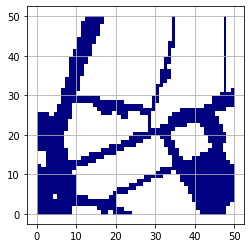

In [212]:
g.visualize()

## Domain - $D_2 Q_{9}$

In [213]:
dico = {}
dico['box'] = box
dico['space_step'] = dx
dico['schemes'] = [{'velocities':list(range(9))}]
dico['elements'] = elements

In [214]:
dom = pylbm.Domain(dico)

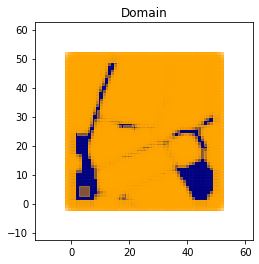

In [215]:
dom.visualize()

# 3D MODEL

## Geometry of the simulation

In [216]:
dx = 1.

In [217]:
# Geometry dictionary and box
d = {}
box = {'x': [0,x_size_2km], 'y': [0, y_size_2km], 'z': [0,z_size_500m], 'label': [0,0,0,0,1,0]}
d['box'] = box

In [218]:
z_size_500m

10

In [219]:
# Elements inside box
elements = []

v0,v1 = [dx, 0., 0.], [0., dx, 0.]
for x in range(x_size_2km) :
    for y in range(y_size_2km) :
        if dict_2d[x][y] > 0:
            v2 = [0.,0.,dict_2d[x][y]]
            elem = pylbm.Parallelepiped([x,y,0], v0,v1,v2, label=1)
            elements.append(elem)
                
d['elements'] = elements

In [220]:
g = pylbm.Geometry(d)

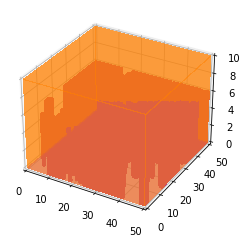

In [221]:
g.visualize()

## Domain - $D_3 Q_{19}$

In [58]:
dico = {}
dico['box'] = box
dico['space_step'] = dx
dico['schemes'] = [{'velocities':list(range(19))}]
dico['elements'] = elements

In [59]:
box

{'x': [0, 10], 'y': [0, 10], 'z': [0, 10], 'label': [0, 0, 0, 0, 1, 0]}

In [60]:
dom = pylbm.Domain(dico)

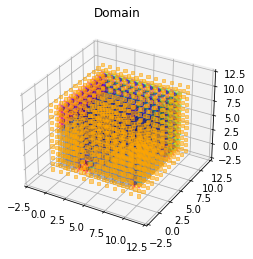

In [61]:
dom.visualize(view_distance=True)

## Scheme

# EXAMPLE

Reynolds number:  5.000e+02
Bulk viscosity :  1.000e-03
Shear viscosity:  2.000e-05
relaxation parameters: [0.0, 0.0, 0.0, 1.4450867052023122, 1.4450867052023122, 1.984757065735154, 1.984757065735154, 1.984757065735154, 1.984757065735154]


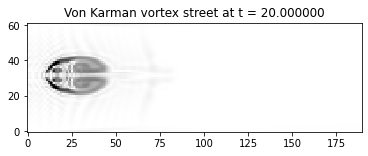

In [75]:
Tf = 20      # final time of the simulation

X, Y, LA = sp.symbols('X, Y, LA')
rho, qx, qy = sp.symbols('rho, qx, qy')

def bc_in(f, m, x, y):
    m[qx] = rhoo * v0

def vorticity(sol):
    ux = sol.m[qx] / sol.m[rho]
    uy = sol.m[qy] / sol.m[rho]
    V = np.abs(uy[2:,1:-1] - uy[0:-2,1:-1] - ux[1:-1,2:] + ux[1:-1,0:-2])/(2*sol.domain.dx)
    return -V

# parameters
rayon = 0.1
Re = 500
dx = 1./64   # spatial step
la = 1.      # velocity of the scheme
v0 = la/20   # maximal velocity obtained in the middle of the channel
rhoo = 1.    # mean value of the density
mu = 1.e-3   # bulk viscosity
eta = rhoo*v0*2*rayon/Re  # shear viscosity
# initialization
xmin, xmax, ymin, ymax = 0., 3., 0., 1.
dummy = 3.0/(la*rhoo*dx)
s_mu = 1.0/(0.5+mu*dummy)
s_eta = 1.0/(0.5+eta*dummy)
s_q = s_eta
s_es = s_mu
s  = [0.,0.,0.,s_mu,s_es,s_q,s_q,s_eta,s_eta]
dummy = 1./(LA**2*rhoo)
qx2 = dummy*qx**2
qy2 = dummy*qy**2
q2  = qx2+qy2
qxy = dummy*qx*qy

print("Reynolds number: {0:10.3e}".format(Re))
print("Bulk viscosity : {0:10.3e}".format(mu))
print("Shear viscosity: {0:10.3e}".format(eta))
print("relaxation parameters: {0}".format(s))

dico = {
    'box': {'x': [xmin, xmax],
            'y': [ymin, ymax],
            'label': [0, 2, 0, 0]
           },
    'elements': [pylbm.Circle([.3, 0.5*(ymin+ymax)+dx], rayon, label=1)],
    'space_step': dx,
    'scheme_velocity': la,
    'parameters': {LA: la},
    'schemes': [
        {
            'velocities': list(range(9)),
            'conserved_moments': [rho, qx, qy],
            'polynomials': [
                1, LA*X, LA*Y,
                3*(X**2+Y**2)-4,
                (9*(X**2+Y**2)**2-21*(X**2+Y**2)+8)/2,
                3*X*(X**2+Y**2)-5*X, 3*Y*(X**2+Y**2)-5*Y,
                X**2-Y**2, X*Y
            ],
            'relaxation_parameters': s,
            'equilibrium': [
                rho, qx, qy,
                -2*rho + 3*q2,
                rho-3*q2,
                -qx/LA, -qy/LA,
                qx2-qy2, qxy
            ],
        },
    ],
    'init': {rho:rhoo,
             qx:0.,
             qy:0.
    },
    'boundary_conditions': {
        0: {'method': {0: pylbm.bc.BouzidiBounceBack}, 'value': bc_in},
        1: {'method': {0: pylbm.bc.BouzidiBounceBack}},
        2: {'method': {0: pylbm.bc.NeumannX}},
    },
    'generator': 'cython',
}

sol = pylbm.Simulation(dico)
while sol.t < Tf:
    sol.one_time_step()

viewer = pylbm.viewer.matplotlib_viewer
fig = viewer.Fig()
ax = fig[0]
im = ax.image(vorticity(sol).transpose(), clim = [-3., 0])
ax.ellipse([.3/dx, 0.5*(ymin+ymax)/dx], [rayon/dx,rayon/dx], 'r')
ax.title = 'Von Karman vortex street at t = {0:f}'.format(sol.t)
fig.show()

In [76]:
import sympy as sp
import pylbm
u, X = sp.symbols('u, X')

d = {
    'dim': 1,
    'scheme_velocity': 1.,
    'schemes': [
        {
            'velocities': [1, 2],
            'conserved_moments': u,
            'polynomials': [1, X],
            'equilibrium': [u, .5*u],
            'relaxation_parameters': [0., 1.9],
        },
    ],
}
s = pylbm.Scheme(d)
print(s)

+--------------------+
| Scheme information |
+--------------------+
    - spatial dimension: 1
    - number of schemes: 1
    - number of velocities: 2
    - conserved moments: [u]
        
    +----------+
    | Scheme 0 |
    +----------+
        - velocities
            (1: 1)
            (2: -1)

        - polynomials
                    
            ⎡1⎤
            ⎢ ⎥
            ⎣X⎦

        - equilibria
                    
            ⎡  u  ⎤
            ⎢     ⎥
            ⎣0.5⋅u⎦

        - relaxation parameters
                    
            ⎡0.0⎤
            ⎢   ⎥
            ⎣1.9⎦

    - moments matrices
                
        ⎡1  1 ⎤
        ⎢     ⎥
        ⎣1  -1⎦

    - inverse of moments matrices
                
        ⎡1/2  1/2 ⎤
        ⎢         ⎥
        ⎣1/2  -1/2⎦

    


+----------------------+
| Geometry information |
+----------------------+
    - spatial dimension: 2
    - bounds of the box: [0. 1.] x [0. 1.]
    - labels: [0, 0, 0, 0]


/home/ajp/.local/lib/python3.8/site-packages/pylbm/viewer/matplotlib_viewer.py:483: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  self.ax.grid(visible, which=which, alpha=alpha)


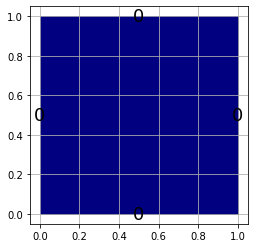

In [77]:
import pylbm
import numpy as np
import pylab as plt
xmin, xmax, ymin, ymax = 0., 1., 0., 1.
dico_geom = {
    'box': {'x': [xmin, xmax],
            'y': [ymin, ymax],
            'label': 0
           },
}
geom = pylbm.Geometry(dico_geom)
print(geom)
geom.visualize(viewlabel=True);


+---------------------+
| Stencil information |
+---------------------+
    - spatial dimension: 2
    - minimal velocity in each direction: [-1 -1]
    - maximal velocity in each direction: [1 1]
    - information for each elementary stencil:
        stencil 0
            - number of velocities: 5
            - velocities
                (0: 0, 0)
                (1: 1, 0)
                (2: 0, 1)
                (3: -1, 0)
                (4: 0, -1)


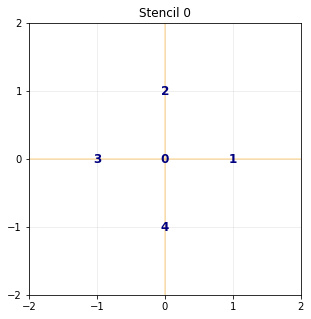

In [78]:
dico_sten = {
    'dim':2,
    'schemes': [
        {'velocities': list(range(5))}
    ],
}
sten = pylbm.Stencil(dico_sten)
print(sten)
sten.visualize();

+--------------------+
| Domain information |
+--------------------+
    - spatial dimension: 2
    - space step: 0.1
    - with halo:
        bounds of the box: [-0.05 -0.05] x [1.05 1.05]
        number of points: [12, 12]
    - without halo:
        bounds of the box: [0.05 0.05] x [0.95 0.95]
        number of points: [10, 10]
        
    +----------------------+
    | Geometry information |
    +----------------------+
        - spatial dimension: 2
        - bounds of the box: [0. 1.] x [0. 1.]
        - labels: [0, 0, 0, 0]


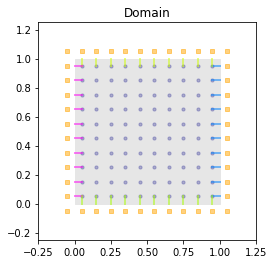

In [79]:
N = 10
dx = (xmax-xmin)/N
dico_dom = {
    'box': {'x': [xmin, xmax],
            'y': [ymin, ymax],
            'label': 0
           },
    'space_step': dx,
    'schemes': [
        {'velocities': list(range(5)),}
    ],
}
dom = pylbm.Domain(dico_dom)
print(dom)
dom.visualize(view_distance=True);

In [80]:
import sympy as sp

def solution(x, y, t):
    return np.sin(np.pi*x)*np.sin(np.pi*y)*np.exp(-2*np.pi**2*mu*t)

# parameters
mu = 1.
la = 1./dx
s1 = 2./(1+4*mu)
s2 = 1.
u, X, Y, LA = sp.symbols('u, X, Y, LA')

dico_sch = {
    'dim': 2,
    'scheme_velocity': la,
    'schemes': [
        {
            'velocities': list(range(5)),
            'conserved_moments': u,
            'polynomials': [1, X/LA, Y/LA, (X**2+Y**2)/(2*LA**2), (X**2-Y**2)/(2*LA**2)],
            'equilibrium': [u, 0., 0., .5*u, 0.],
            'relaxation_parameters': [0., s1, s1, s2, s2],
        }
    ],
    'parameters': {LA: la},
}

sch = pylbm.Scheme(dico_sch)
print(sch)

+--------------------+
| Scheme information |
+--------------------+
    - spatial dimension: 2
    - number of schemes: 1
    - number of velocities: 5
    - conserved moments: [u]
        
    +----------+
    | Scheme 0 |
    +----------+
        - velocities
            (0: 0, 0)
            (1: 1, 0)
            (2: 0, 1)
            (3: -1, 0)
            (4: 0, -1)

        - polynomials
                    
            ⎡   1   ⎤
            ⎢       ⎥
            ⎢  X    ⎥
            ⎢  ──   ⎥
            ⎢  LA   ⎥
            ⎢       ⎥
            ⎢  Y    ⎥
            ⎢  ──   ⎥
            ⎢  LA   ⎥
            ⎢       ⎥
            ⎢ 2    2⎥
            ⎢X  + Y ⎥
            ⎢───────⎥
            ⎢     2 ⎥
            ⎢ 2⋅LA  ⎥
            ⎢       ⎥
            ⎢ 2    2⎥
            ⎢X  - Y ⎥
            ⎢───────⎥
            ⎢     2 ⎥
            ⎣ 2⋅LA  ⎦

        - equilibria
                    
            ⎡  u  ⎤
            ⎢     ⎥
            ⎢ 0.0 ⎥
            ⎢   

In [81]:
dico = {
    'box': {'x': [xmin, xmax],
            'y': [ymin, ymax],
            'label': 0},
    'space_step': dx,
    'scheme_velocity': la,
    'schemes': [
        {
            'velocities': list(range(5)),
            'conserved_moments': u,
            'polynomials': [1, X/LA, Y/LA, (X**2+Y**2)/(2*LA**2), (X**2-Y**2)/(2*LA**2)],
            'equilibrium': [u, 0., 0., .5*u, 0.],
            'relaxation_parameters': [0., s1, s1, s2, s2],
        }
    ],
    'init': {u: (solution, (0.,))},
    'boundary_conditions': {
        0: {'method': {0: pylbm.bc.AntiBounceBack,}},
    },
    'parameters': {LA: la},
}

sol = pylbm.Simulation(dico)
print(sol)

+------------------------+
| Simulation information |
+------------------------+
        
    +--------------------+
    | Domain information |
    +--------------------+
        - spatial dimension: 2
        - space step: 0.1
        - with halo:
            bounds of the box: [-0.05 -0.05] x [1.05 1.05]
            number of points: [12, 12]
        - without halo:
            bounds of the box: [0.05 0.05] x [0.95 0.95]
            number of points: [10, 10]
            
        +----------------------+
        | Geometry information |
        +----------------------+
            - spatial dimension: 2
            - bounds of the box: [0. 1.] x [0. 1.]
            - labels: [0, 0, 0, 0]
        
    +--------------------+
    | Scheme information |
    +--------------------+
        - spatial dimension: 2
        - number of schemes: 1
        - number of velocities: 5
        - conserved moments: [u]
            
        +----------+
        | Scheme 0 |
        +----------+
     

[[-0.00390625]
 [ 0.00390625]
 [ 0.01171875]
 [ 0.01953125]
 [ 0.02734375]
 [ 0.03515625]
 [ 0.04296875]
 [ 0.05078125]
 [ 0.05859375]
 [ 0.06640625]
 [ 0.07421875]
 [ 0.08203125]
 [ 0.08984375]
 [ 0.09765625]
 [ 0.10546875]
 [ 0.11328125]
 [ 0.12109375]
 [ 0.12890625]
 [ 0.13671875]
 [ 0.14453125]
 [ 0.15234375]
 [ 0.16015625]
 [ 0.16796875]
 [ 0.17578125]
 [ 0.18359375]
 [ 0.19140625]
 [ 0.19921875]
 [ 0.20703125]
 [ 0.21484375]
 [ 0.22265625]
 [ 0.23046875]
 [ 0.23828125]
 [ 0.24609375]
 [ 0.25390625]
 [ 0.26171875]
 [ 0.26953125]
 [ 0.27734375]
 [ 0.28515625]
 [ 0.29296875]
 [ 0.30078125]
 [ 0.30859375]
 [ 0.31640625]
 [ 0.32421875]
 [ 0.33203125]
 [ 0.33984375]
 [ 0.34765625]
 [ 0.35546875]
 [ 0.36328125]
 [ 0.37109375]
 [ 0.37890625]
 [ 0.38671875]
 [ 0.39453125]
 [ 0.40234375]
 [ 0.41015625]
 [ 0.41796875]
 [ 0.42578125]
 [ 0.43359375]
 [ 0.44140625]
 [ 0.44921875]
 [ 0.45703125]
 [ 0.46484375]
 [ 0.47265625]
 [ 0.48046875]
 [ 0.48828125]
 [ 0.49609375]
 [ 0.50390625]
 [ 0.51171

TypeError: Invalid shape () for image data

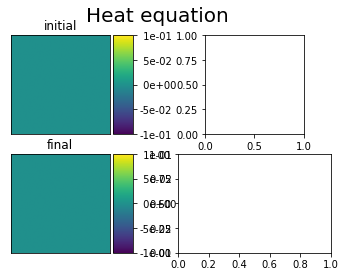

In [90]:
import numpy as np
import sympy as sp
import pylab as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pylbm

u, X, Y = sp.symbols('u, X, Y')

def solution(x, y, t, k, l):
    print(x)
    if (sum(x) < ) and (sum(y) < 10) :
        return 1
    else :
        return 0
    #return np.sin(k*np.pi*x)*np.sin(l*np.pi*y)*np.exp(-(k**2+l**2)*np.pi**2*mu*t)

def plot(i, j, z, title):
    im = axarr[i,j].imshow(z)
    divider = make_axes_locatable(axarr[i, j])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, format='%6.0e')
    axarr[i, j].xaxis.set_visible(False)
    axarr[i, j].yaxis.set_visible(False)
    axarr[i, j].set_title(title)

# parameters
xmin, xmax, ymin, ymax = 0., 1., 0., 1.
N = 128
mu = 1.
Tf = .1
dx = (xmax-xmin)/N # spatial step
la = 1./dx
s1 = 2./(1+4*mu)
s2 = 1.
k, l = 1, 1 # number of the wave

dico = {
    'box': {'x':[xmin, xmax],
            'y':[ymin, ymax],
            'label': 0},
    'space_step': dx,
    'scheme_velocity': la,
    'schemes':[
        {
            'velocities': list(range(5)),
            'conserved_moments': u,
            'polynomials': [1, X/LA, Y/LA, (X**2+Y**2)/(2*LA**2), (X**2-Y**2)/(2*LA**2)],
            'equilibrium': [u, 0., 0., .5*u, 0.],
            'relaxation_parameters': [0., s1, s1, s2, s2],
        }
    ],
    'init': {u: (solution, (0., k, l))},
    'boundary_conditions': {
        0: {'method': {0: pylbm.bc.AntiBounceBack,}},
    },
    'generator': 'cython',
    'parameters': {LA: la},
}

sol = pylbm.Simulation(dico)
x = sol.domain.x
y = sol.domain.y

f, axarr = plt.subplots(2, 2)
f.suptitle('Heat equation', fontsize=20)

plot(0, 0, sol.m[u].copy(), 'initial')

while sol.t < Tf:
    sol.one_time_step()

sol.f2m()
z = sol.m[u]
ze = solution(x[:, np.newaxis], y[np.newaxis, :], sol.t, k, l)
plot(1, 0, z, 'final')
plot(0, 1, ze, 'exact')
plot(1, 1, z-ze, 'error')

plt.show()